# Reconstruction of the upper-mid-ocean AMOC with the gridded mooring product form RAPID

This notebook will investige if there is there a linear correlation between the gridded mooring densities from RAPID and the upper_mid_ocean AMOC strength.
All salt and temeprature values are mapped to the insitu density and all NaN values are filled with zeros.
The resulting large dataset is decomposed with PCA into lower dimension.

For the linear prediction a MSE error is used togeteher with a L2-norm weight relgularization.

In [1]:
import xarray as xr
import gsw.density as density
import gsw.conversions as conversions
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge


In [2]:
#avoid the nan values in the beginning and the end of the time series
mooring_data = xr.open_dataset('data/ts_gridded.nc').sel(time = slice('2004-04-7', '2022-01-31'))
moc_data = xr.open_dataset('data/moc_transports.nc').sel(time = slice('2004-04-7', '2022-01-31'))

In [3]:
all_inputs = xr.concat([
    mooring_data.TG_west, mooring_data.SG_west,
    mooring_data.TG_east, mooring_data.SG_east,
    mooring_data.TG_wb3, mooring_data.SG_wb3,
    mooring_data.TG_marwest, mooring_data.SG_marwest,
    mooring_data.TG_mareast, mooring_data.SG_mareast,
], dim='depth').fillna(0).T

In [4]:
ct  = conversions.CT_from_pt(mooring_data.SG_west, mooring_data.TG_west)
rho_west = (density.rho(mooring_data.SG_west, ct, mooring_data.pressure) - 1000).fillna(0) 

ct  = conversions.CT_from_pt(mooring_data.SG_east, mooring_data.TG_east)
rho_east = (density.rho(mooring_data.SG_east, ct, mooring_data.pressure) - 1000).fillna(0)

ct  = conversions.CT_from_pt(mooring_data.SG_wb3, mooring_data.TG_wb3)
rho_wb3 = (density.rho(mooring_data.SG_wb3, ct, mooring_data.pressure) - 1000).fillna(0)

ct  = conversions.CT_from_pt(mooring_data.SG_marwest, mooring_data.TG_marwest)
rho_marwest = (density.rho(mooring_data.SG_marwest, ct, mooring_data.pressure) - 1000).fillna(0)

ct  = conversions.CT_from_pt(mooring_data.SG_mareast, mooring_data.TG_mareast)
rho_mareast = (density.rho(mooring_data.SG_mareast, ct, mooring_data.pressure) - 1000).fillna(0)

all_inputs = xr.concat([
    rho_west, rho_east, rho_wb3, rho_marwest, rho_mareast
], dim='depth').T

In [26]:
output = moc_data.t_umo10#.rolling(time=365*2).mean().fillna(0)

In [27]:

train_set = all_inputs.sel(time=slice('2004-01-01', '2014-12-31'))
test_set = all_inputs.sel(time=slice('2015-01-01', None))

train_output = output.sel(time=slice('2004-01-01', '2014-12-31'))
test_output = output.sel(time=slice('2015-01-01', None))

In [28]:
pca = PCA(n_components=10)
pca.fit(train_set.values)

print(np.cumsum(pca.explained_variance_ratio_))

[0.30311963 0.46839059 0.58768347 0.66486821 0.72275641 0.76968418
 0.80091208 0.82880258 0.85504558 0.87528864]


In [29]:
transformed_train_input = pca.transform(train_set.values)
transformed_test_input = pca.transform(test_set.values)

In [36]:
linear_model = Lasso(alpha=1).fit(transformed_train_input, train_output.values)
linear_model.score(transformed_test_input, test_output.values)

-0.3937471908816097

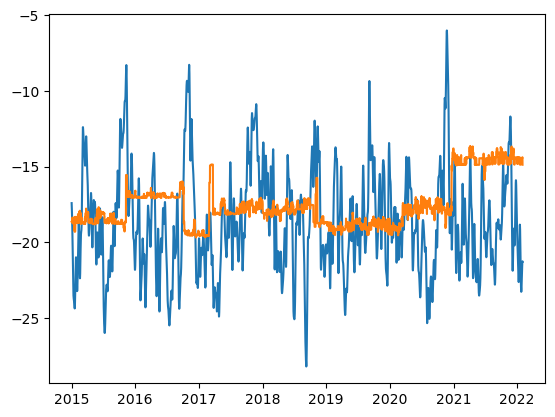

In [37]:
# plot the results
plt.plot(test_output.time, test_output)
plt.plot(test_output.time,linear_model.predict(transformed_test_input))
plt.show()

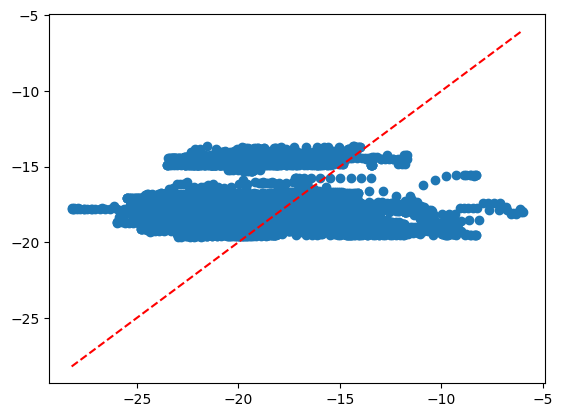

In [39]:
plt.scatter(test_output,linear_model.predict(transformed_test_input))

min_value = min(np.min(test_output), np.min(linear_model.predict(transformed_test_input)))
max_value = max(np.max(test_output), np.max(linear_model.predict(transformed_test_input)))
plt.plot([min_value, max_value], [min_value, max_value], 'r--')
plt.show()